---
Reading the MNIST data set
---

In [2]:

import numpy as np
import matplotlib.pyplot as plt

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
train_data = np.loadtxt("mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt("mnist_test.csv", 
                       delimiter=",") 
test_data[:10]

array([[7., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [4]:
test_data[test_data==255]
test_data.shape

(10000, 785)

The images of the MNIST dataset are greyscale and the pixels range between 0 and 255 including both bounding values. We will map these values into an interval from [0.01, 1] by multiplying each pixel by 0.99 / 255 and adding 0.01 to the result. This way, we avoid 0 values as inputs, which are capable of preventing weight updates, as we we seen in the introductory chapter.

In [5]:
fac = 0.99 / 255
train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * fac + 0.01

train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

We need the labels in our calculations in a one-hot representation. We have 10 digits from 0 to 9, i.e. lr = np.arange(10).

Turning a label into one-hot representation can be achieved with the command: (lr==label).astype(np.int)

We demonstrate this in the following:

In [6]:
import numpy as np

lr = np.arange(10)

for label in range(10):
    one_hot = (lr==label).astype(np.int)
    print("label: ", label, " in one-hot representation: ", one_hot)

label:  0  in one-hot representation:  [1 0 0 0 0 0 0 0 0 0]
label:  1  in one-hot representation:  [0 1 0 0 0 0 0 0 0 0]
label:  2  in one-hot representation:  [0 0 1 0 0 0 0 0 0 0]
label:  3  in one-hot representation:  [0 0 0 1 0 0 0 0 0 0]
label:  4  in one-hot representation:  [0 0 0 0 1 0 0 0 0 0]
label:  5  in one-hot representation:  [0 0 0 0 0 1 0 0 0 0]
label:  6  in one-hot representation:  [0 0 0 0 0 0 1 0 0 0]
label:  7  in one-hot representation:  [0 0 0 0 0 0 0 1 0 0]
label:  8  in one-hot representation:  [0 0 0 0 0 0 0 0 1 0]
label:  9  in one-hot representation:  [0 0 0 0 0 0 0 0 0 1]


#We are ready now to turn our labelled images into one-hot representations. 
#Instead of zeroes and one, we create 0.01 and 0.99, which will be better for our calculations:

In [7]:
lr = np.arange(no_of_different_labels)

# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float)
test_labels_one_hot = (lr==test_labels).astype(np.float)

# we don't want zeroes and ones in the labels neither:
train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99

#Before we start using the MNIST data sets with our neural network, we will have a look at some images:

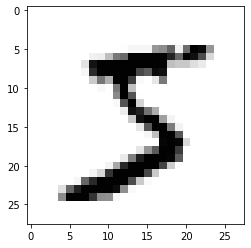

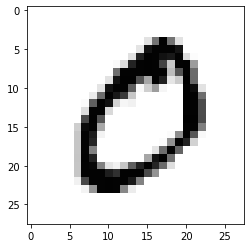

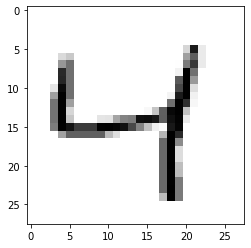

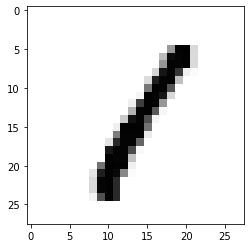

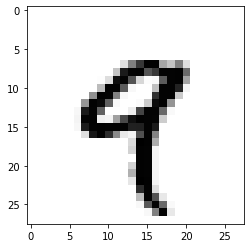

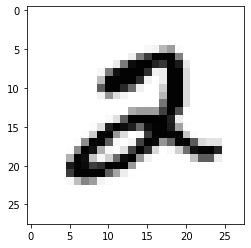

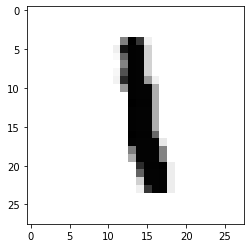

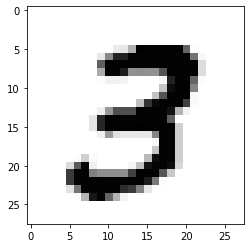

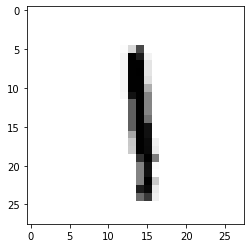

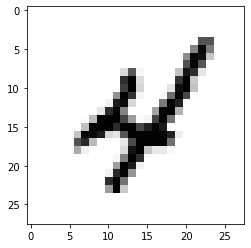

In [8]:
for i in range(10):
    img = train_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

---
Dumping the Data for Faster Reload
---
You may have noticed that it is quite slow to read in the data from the csv files.

We will save the data in binary format with the dump function from the pickle module:

In [10]:
import pickle

with open("pickled_mnist.pkl", "bw") as fh:
    data = (train_imgs, 
            test_imgs, 
            train_labels,
            test_labels,
            train_labels_one_hot,
            test_labels_one_hot)
    pickle.dump(data, fh)

We are able now to read in the data by using pickle.load. This is a lot faster than using loadtxt on the csv files:

In [11]:
import pickle

with open("pickled_mnist.pkl", "br") as fh:
    data = pickle.load(fh)

train_imgs = data[0]
test_imgs = data[1]
train_labels = data[2]
test_labels = data[3]
train_labels_one_hot = data[4]
test_labels_one_hot = data[5]

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size

---
Classifying the Data
---
We will use the following neuronal network class for our first classification:

In [12]:
import numpy as np

@np.vectorize
def sigmoid(x):
    return 1 / (1 + np.e ** -x)
activation_function = sigmoid

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)

In [13]:
class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network
        """
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                         self.no_of_hidden_nodes))
        
    
    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can 
        be tuple, list or ndarray
        """
        
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T
        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network \
              * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * \
              (1.0 - output_hidden)
        self.wih += self.learning_rate \
                          * np.dot(tmp, input_vector.T)
        

        
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
            
    def confusion_matrix(self, data_array, labels):
        cm = np.zeros((10, 10), int)
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            cm[res_max, int(target)] += 1
        return cm    

    def precision(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()
    
    def recall(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
        
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [14]:
ANN = NeuralNetwork(no_of_in_nodes = image_pixels, 
                    no_of_out_nodes = 10, 
                    no_of_hidden_nodes = 100,
                    learning_rate = 0.1)

In [15]:
for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], train_labels_one_hot[i])

In [16]:
for i in range(20):
    res = ANN.run(test_imgs[i])
    print(test_labels[i], np.argmax(res), np.max(res))

[7.] 7 0.9946084113480487
[2.] 2 0.8316255786585525
[1.] 1 0.9937871450791433
[0.] 0 0.9727236287406174
[4.] 4 0.9743522654322594
[1.] 1 0.9891660027740605
[4.] 4 0.9804594873103954
[9.] 9 0.9164984153371314
[5.] 6 0.2686481620832586
[9.] 9 0.9683773273138732
[0.] 0 0.9680800692465874
[6.] 6 0.8647948153130123
[9.] 9 0.9915541070737977
[0.] 0 0.9937366398695114
[1.] 1 0.9927222384475506
[5.] 5 0.9172712877146926
[9.] 9 0.9924501871191468
[7.] 7 0.9879949835165412
[3.] 3 0.836444016623964
[4.] 4 0.9798692568967728


In [17]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", corrects / ( corrects + wrongs))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy: test", corrects / ( corrects + wrongs))

cm = ANN.confusion_matrix(train_imgs, train_labels)
print(cm)

for i in range(10):
    print("digit: ", i, "precision: ", ANN.precision(i, cm), "recall: ", ANN.recall(i, cm))

accuracy train:  0.9491
accuracy: test 0.9475
[[5816    1   56   13    8   44   38    9   22   33]
 [   0 6631   42   22   15   35   16   50   98   14]
 [   5   24 5522   63   12   18    5   49   20    4]
 [   1   31   94 5800    1  148    2   23  127   78]
 [  15   12   63   10 5512   32   10   37   31   93]
 [   1    4    2   46    1 4948   29    2   14    6]
 [  38    5   57   27   52   75 5781    5   38    2]
 [   1    5   41   53    8   11    0 5878    3   34]
 [  40   14   67   46   15   62   37   12 5406   33]
 [   6   15   14   51  218   48    0  200   92 5652]]
digit:  0 precision:  0.9819348303224718 recall:  0.9629139072847682
digit:  1 precision:  0.9835360427172946 recall:  0.9578217535750397
digit:  2 precision:  0.9268210808996308 recall:  0.9650471862984971
digit:  3 precision:  0.9460120698091665 recall:  0.9199048374306106
digit:  4 precision:  0.9435124957206437 recall:  0.9478933791917454
digit:  5 precision:  0.912746725696366 recall:  0.9792202651889966
digit:  6 

---
Multiple Runs
---
#We can repeat the training multiple times. Each run is called an "epoch".

In [18]:
epochs = 3

NN = NeuralNetwork(no_of_in_nodes = image_pixels, 
                   no_of_out_nodes = 10, 
                   no_of_hidden_nodes = 100,
                   learning_rate = 0.1)


for epoch in range(epochs):  
    print("epoch: ", epoch)
    for i in range(len(train_imgs)):
        NN.train(train_imgs[i], 
                 train_labels_one_hot[i])
  
    corrects, wrongs = NN.evaluate(train_imgs, train_labels)
    print("accuracy train: ", corrects / ( corrects + wrongs))
    corrects, wrongs = NN.evaluate(test_imgs, test_labels)
    print("accuracy: test", corrects / ( corrects + wrongs))

epoch:  0
accuracy train:  0.9488
accuracy: test 0.9487
epoch:  1
accuracy train:  0.9623666666666667
accuracy: test 0.9565
epoch:  2
accuracy train:  0.9706166666666667
accuracy: test 0.9621


#We want to do the multiple training of the training set inside of our network. 
#To this purpose we rewrite the method train and add a method train_single. train_single is more or less what we called 'train' before. 
#Whereas the new 'train' method is doing the epoch counting. For testing purposes, we save the weight matrices after each epoch in
#the list intermediate_weights. This list is returned as the output of train:


In [19]:

import numpy as np

@np.vectorize
def sigmoid(x):
    return 1 / (1 + np.e ** -x)
activation_function = sigmoid

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork:
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural network"""
        rad = 1 / np.sqrt(self.no_of_in_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                                       self.no_of_in_nodes))
        rad = 1 / np.sqrt(self.no_of_hidden_nodes)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                                        self.no_of_hidden_nodes))
        
    
    def train_single(self, input_vector, target_vector):
        """
        input_vector and target_vector can be tuple, 
        list or ndarray
        """
        
        output_vectors = []
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network * \
              (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * (1.0 - output_hidden)
        self.wih += self.learning_rate * np.dot(tmp, input_vector.T)
        

    def train(self, data_array, 
              labels_one_hot_array,
              epochs=1,
              intermediate_results=False):
        intermediate_weights = []
        for epoch in range(epochs):  
            print("*", end="")
            for i in range(len(data_array)):
                self.train_single(data_array[i], 
                                  labels_one_hot_array[i])
            if intermediate_results:
                intermediate_weights.append((self.wih.copy(), 
                                             self.who.copy()))
        return intermediate_weights        
            
    def confusion_matrix(self, data_array, labels):
        cm = {}
        for i in range(len(data_array)):
            res = self.run(data_array[i])
            res_max = res.argmax()
            target = labels[i][0]
            if (target, res_max) in cm:
                cm[(target, res_max)] += 1
            else:
                cm[(target, res_max)] = 1
        return cm
        
    
    def run(self, input_vector):
        """ input_vector can be tuple, list or ndarray """
        
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [20]:
epochs = 10

ANN = NeuralNetwork(no_of_in_nodes = image_pixels, 
                               no_of_out_nodes = 10, 
                               no_of_hidden_nodes = 100,
                               learning_rate = 0.15)
    
    
 
weights = ANN.train(train_imgs, 
                    train_labels_one_hot, 
                    epochs=epochs, 
                    intermediate_results=True)

**********

In [21]:
cm = ANN.confusion_matrix(train_imgs, train_labels)
        
print(ANN.run(train_imgs[i]))

[[2.47628066e-02]
 [8.31205638e-03]
 [1.15186767e-04]
 [5.25863400e-03]
 [8.96510557e-04]
 [8.57431726e-03]
 [5.43086905e-05]
 [2.19589572e-04]
 [9.99669754e-01]
 [1.99263760e-02]]


In [22]:
cm = list(cm.items())
print(sorted(cm))

[((0.0, 0), 5858), ((0.0, 2), 2), ((0.0, 3), 2), ((0.0, 4), 13), ((0.0, 5), 3), ((0.0, 6), 15), ((0.0, 8), 25), ((0.0, 9), 5), ((1.0, 0), 1), ((1.0, 1), 6674), ((1.0, 2), 19), ((1.0, 3), 7), ((1.0, 4), 7), ((1.0, 5), 7), ((1.0, 7), 8), ((1.0, 8), 15), ((1.0, 9), 4), ((2.0, 0), 45), ((2.0, 1), 15), ((2.0, 2), 5800), ((2.0, 3), 18), ((2.0, 4), 18), ((2.0, 5), 8), ((2.0, 6), 6), ((2.0, 7), 17), ((2.0, 8), 28), ((2.0, 9), 3), ((3.0, 0), 27), ((3.0, 1), 4), ((3.0, 2), 33), ((3.0, 3), 5898), ((3.0, 4), 8), ((3.0, 5), 60), ((3.0, 6), 5), ((3.0, 7), 20), ((3.0, 8), 49), ((3.0, 9), 27), ((4.0, 0), 26), ((4.0, 1), 12), ((4.0, 2), 3), ((4.0, 3), 1), ((4.0, 4), 5700), ((4.0, 6), 13), ((4.0, 7), 8), ((4.0, 8), 14), ((4.0, 9), 65), ((5.0, 0), 18), ((5.0, 1), 5), ((5.0, 2), 4), ((5.0, 3), 41), ((5.0, 4), 6), ((5.0, 5), 5263), ((5.0, 6), 23), ((5.0, 7), 1), ((5.0, 8), 32), ((5.0, 9), 28), ((6.0, 0), 84), ((6.0, 1), 8), ((6.0, 2), 2), ((6.0, 4), 20), ((6.0, 5), 23), ((6.0, 6), 5741), ((6.0, 8), 40), ((

In [23]:
for i in range(epochs):  
    print("epoch: ", i)
    ANN.wih = weights[i][0]
    ANN.who = weights[i][1]
   
    corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
    print("accuracy train: ", corrects / ( corrects + wrongs))
    corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
    print("accuracy: test", corrects / ( corrects + wrongs))

epoch:  0
accuracy train:  0.951
accuracy: test 0.9484
epoch:  1
accuracy train:  0.9569
accuracy: test 0.9486
epoch:  2
accuracy train:  0.96405
accuracy: test 0.9558
epoch:  3
accuracy train:  0.96435
accuracy: test 0.9534
epoch:  4
accuracy train:  0.9650333333333333
accuracy: test 0.9562
epoch:  5
accuracy train:  0.9690166666666666
accuracy: test 0.9566
epoch:  6
accuracy train:  0.9711333333333333
accuracy: test 0.9598
epoch:  7
accuracy train:  0.9721
accuracy: test 0.9562
epoch:  8
accuracy train:  0.97295
accuracy: test 0.9601
epoch:  9
accuracy train:  0.9714666666666667
accuracy: test 0.9593


---
With Bias Nodes
---

In [25]:
import numpy as np

@np.vectorize
def sigmoid(x):
    return 1 / (1 + np.e ** -x)
activation_function = sigmoid

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork:
        
    
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate,
                 bias=None
                ):  

        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes      
        self.no_of_hidden_nodes = no_of_hidden_nodes     
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()
    
        
    
    def create_weight_matrices(self):
        """ 
        A method to initialize the weight 
        matrices of the neural network with 
        optional bias nodes
        """
        
        bias_node = 1 if self.bias else 0
        
        rad = 1 / np.sqrt(self.no_of_in_nodes + bias_node)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                          self.no_of_in_nodes + bias_node))

        rad = 1 / np.sqrt(self.no_of_hidden_nodes + bias_node)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                          self.no_of_hidden_nodes + bias_node))
        
        
        
    def train(self, input_vector, target_vector):
        """ 
        input_vector and target_vector can 
        be tuple, list or ndarray
        """
        
        bias_node = 1 if self.bias else 0
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate((input_vector, 
                                           [self.bias]) )
                                    
            
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        if self.bias:
            output_hidden = np.concatenate((output_hidden, 
                                            [[self.bias]]) )
        
        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network * (1.0 - output_network)     
        tmp = self.learning_rate  * np.dot(tmp, output_hidden.T)
        self.who += tmp


        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * (1.0 - output_hidden)
        if self.bias:
            x = np.dot(tmp, input_vector.T)[:-1,:]     
        else:
            x = np.dot(tmp, input_vector.T)
        self.wih += self.learning_rate * x
        
       
    
    def run(self, input_vector):
        """
        input_vector can be tuple, list or ndarray
        """
        
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate((input_vector, [1]) )
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        if self.bias:
            output_vector = np.concatenate( (output_vector, 
                                             [[1]]) )
            

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
        return output_vector
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [26]:
ANN = NeuralNetwork(no_of_in_nodes=image_pixels, 
                    no_of_out_nodes=10, 
                    no_of_hidden_nodes=200,
                    learning_rate=0.1,
                    bias=None)
    
    
for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], train_labels_one_hot[i])
for i in range(20):
    res = ANN.run(test_imgs[i])
    print(test_labels[i], np.argmax(res), np.max(res))

[7.] 7 0.9934951948599736
[2.] 2 0.9256015277907452
[1.] 1 0.9900151075820861
[0.] 0 0.963851284804999
[4.] 4 0.9480539370968422
[1.] 1 0.988374562303409
[4.] 4 0.9739467899987087
[9.] 9 0.9829355345372894
[5.] 6 0.4581403414865298
[9.] 9 0.9895002858470044
[0.] 0 0.9880533630474012
[6.] 6 0.8582770923463678
[9.] 9 0.9952806040933867
[0.] 0 0.9899474117896598
[1.] 1 0.9881921505001295
[5.] 5 0.9305312693115744
[9.] 9 0.9883519946542543
[7.] 7 0.9797936882643336
[3.] 3 0.8409929557455251
[4.] 4 0.9907060648139673


In [27]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", corrects / ( corrects + wrongs))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy: test", corrects / ( corrects + wrongs))

accuracy train:  0.95365
accuracy: test 0.9523


---
Version with Bias and Epochs:
---

In [28]:
import numpy as np

@np.vectorize
def sigmoid(x):
    return 1 / (1 + np.e ** -x)
activation_function = sigmoid

from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd,
                     (upp - mean) / sd,
                     loc=mean,
                     scale=sd)


class NeuralNetwork:
 
    def __init__(self, 
                 no_of_in_nodes, 
                 no_of_out_nodes, 
                 no_of_hidden_nodes,
                 learning_rate,
                 bias=None
                ):  

        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        
        self.no_of_hidden_nodes = no_of_hidden_nodes
            
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()
    
        
    
    def create_weight_matrices(self):
        """ 
        A method to initialize the weight matrices 
        of the neural network with optional 
        bias nodes"""
        
        bias_node = 1 if self.bias else 0
        
        rad = 1 / np.sqrt(self.no_of_in_nodes + bias_node)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.wih = X.rvs((self.no_of_hidden_nodes, 
                          self.no_of_in_nodes + bias_node))

        rad = 1 / np.sqrt(self.no_of_hidden_nodes + bias_node)
        X = truncated_normal(mean=0, 
                             sd=1, 
                             low=-rad, 
                             upp=rad)
        self.who = X.rvs((self.no_of_out_nodes, 
                          self.no_of_hidden_nodes + bias_node))
        
 
    def train_single(self, input_vector, target_vector):
        """
        input_vector and target_vector can be tuple, 
        list or ndarray
        """

        bias_node = 1 if self.bias else 0
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, 
                                            [self.bias]) )
        
        output_vectors = []
        input_vector = np.array(input_vector, ndmin=2).T
        target_vector = np.array(target_vector, ndmin=2).T

        
        output_vector1 = np.dot(self.wih, 
                                input_vector)
        output_hidden = activation_function(output_vector1)
        
        if self.bias:
            output_hidden = np.concatenate((output_hidden, 
                                            [[self.bias]]) )

        
        output_vector2 = np.dot(self.who, 
                                output_hidden)
        output_network = activation_function(output_vector2)
        
        output_errors = target_vector - output_network
        # update the weights:
        tmp = output_errors * output_network * (1.0 - output_network)          
        tmp = self.learning_rate  * np.dot(tmp, 
                                           output_hidden.T) 
        self.who += tmp

        
        # calculate hidden errors:
        hidden_errors = np.dot(self.who.T, 
                               output_errors)
        # update the weights:
        tmp = hidden_errors * output_hidden * (1.0 - output_hidden)
        if self.bias:
            x = np.dot(tmp, input_vector.T)[:-1,:] 
        else:
            x = np.dot(tmp, input_vector.T)
        self.wih += self.learning_rate * x
        

    def train(self, data_array, 
              labels_one_hot_array,
              epochs=1,
              intermediate_results=False):
        intermediate_weights = []
        for epoch in range(epochs):  
            for i in range(len(data_array)):
                self.train_single(data_array[i], 
                                  labels_one_hot_array[i])
            if intermediate_results:
                intermediate_weights.append((self.wih.copy(), 
                                             self.who.copy()))
        return intermediate_weights      
        

        
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray
        
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, 
                                            [self.bias]) )
        input_vector = np.array(input_vector, ndmin=2).T

        output_vector = np.dot(self.wih, 
                               input_vector)
        output_vector = activation_function(output_vector)
        
        if self.bias:
            output_vector = np.concatenate( (output_vector, 
                                             [[self.bias]]) )
            

        output_vector = np.dot(self.who, 
                               output_vector)
        output_vector = activation_function(output_vector)
    
        return output_vector
    
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [29]:
epochs = 12

network = NeuralNetwork(no_of_in_nodes=image_pixels, 
                        no_of_out_nodes=10, 
                        no_of_hidden_nodes=100,
                        learning_rate=0.1,
                        bias=None)

weights = network.train(train_imgs, 
                        train_labels_one_hot, 
                        epochs=epochs, 
                        intermediate_results=True) 
for epoch in range(epochs):  
    print("epoch: ", epoch)
    network.wih = weights[epoch][0]
    network.who = weights[epoch][1]
    corrects, wrongs = network.evaluate(train_imgs, 
                                        train_labels)
    print("accuracy train: ", corrects / ( corrects + wrongs))                   
    corrects, wrongs = network.evaluate(test_imgs, 
                                        test_labels)
    print("accuracy test: ", corrects / ( corrects + wrongs)) 

epoch:  0
accuracy train:  0.9454166666666667
accuracy test:  0.944
epoch:  1
accuracy train:  0.9612166666666667
accuracy test:  0.9565
epoch:  2
accuracy train:  0.9638666666666666
accuracy test:  0.9574
epoch:  3
accuracy train:  0.9696666666666667
accuracy test:  0.9621
epoch:  4
accuracy train:  0.9721833333333333
accuracy test:  0.9636
epoch:  5
accuracy train:  0.9734333333333334
accuracy test:  0.9636
epoch:  6
accuracy train:  0.9742
accuracy test:  0.9616
epoch:  7
accuracy train:  0.9731666666666666
accuracy test:  0.9623
epoch:  8
accuracy train:  0.9765
accuracy test:  0.9627
epoch:  9
accuracy train:  0.9760166666666666
accuracy test:  0.9647
epoch:  10
accuracy train:  0.9733333333333334
accuracy test:  0.9606
epoch:  11
accuracy train:  0.9752666666666666
accuracy test:  0.9607


In [ ]:
epochs = 12


with open("nist_tests.csv", "w") as fh_out:  
    for hidden_nodes in [20, 50, 100, 120, 150]:
        for learning_rate in [0.01, 0.05, 0.1, 0.2]:
            for bias in [None, 0.5]:
                network = NeuralNetwork(no_of_in_nodes=image_pixels, 
                                       no_of_out_nodes=10, 
                                       no_of_hidden_nodes=hidden_nodes,
                                       learning_rate=learning_rate,
                                       bias=bias)
                weights = network.train(train_imgs, 
                                       train_labels_one_hot, 
                                       epochs=epochs, 
                                       intermediate_results=True) 
                for epoch in range(epochs):  
                    print("*", end="")
                    network.wih = weights[epoch][0]
                    network.who = weights[epoch][1]
                    train_corrects, train_wrongs = network.evaluate(train_imgs, 
                                                                    train_labels)
                    
                    test_corrects, test_wrongs = network.evaluate(test_imgs, 
                                                                  test_labels)
                    outstr = str(hidden_nodes) + " " + str(learning_rate) + " " + str(bias) 
                    outstr += " " + str(epoch) + " "
                    outstr += str(train_corrects / (train_corrects + train_wrongs)) + " "
                    outstr += str(train_wrongs / (train_corrects + train_wrongs)) + " "
                    outstr += str(test_corrects / (test_corrects + test_wrongs)) + " "
                    outstr += str(test_wrongs / (test_corrects + test_wrongs)) 
                    
                    fh_out.write(outstr + "\n" )
                    fh_out.flush()

---
Networks with multiple hidden layers
---
We will write a new neural network class, in which we can define an arbitrary number of hidden layers. The code is also improved, because the weight matrices are now build inside of a loop instead redundant code:



In [ ]:
import numpy as np
from scipy.special import expit as activation_function
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, 
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork:
        
    
    def __init__(self, 
                 network_structure, # ie. [input_nodes, hidden1_nodes, ... , hidden_n_nodes, output_nodes]
                 learning_rate,
                 bias=None
                ):  

        self.structure = network_structure
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()
    
    
    def create_weight_matrices(self):
        
        bias_node = 1 if self.bias else 0
        self.weights_matrices = []
        
        layer_index = 1
        no_of_layers = len(self.structure)
        while layer_index < no_of_layers:
            nodes_in = self.structure[layer_index-1]
            nodes_out = self.structure[layer_index]
            n = (nodes_in + bias_node) * nodes_out
            rad = 1 / np.sqrt(nodes_in)
            X = truncated_normal(mean=2, 
                                 sd=1, 
                                 low=-rad, 
                                 upp=rad)
            wm = X.rvs(n).reshape((nodes_out, nodes_in + bias_node))
            self.weights_matrices.append(wm)
            layer_index += 1

        
        
    def train(self, input_vector, target_vector):
        """
        input_vector and target_vector can be tuple, 
        list or ndarray
        """                              

        no_of_layers = len(self.structure)
        input_vector = np.array(input_vector, ndmin=2).T
        layer_index = 0
        # The output/input vectors of the various layers:
        res_vectors = [input_vector]
        while layer_index < no_of_layers - 1:
            in_vector = res_vectors[-1]
            if self.bias:
                # adding bias node to the end of the 'input'_vector
                in_vector = np.concatenate( (in_vector, 
                                             [[self.bias]]) )
                res_vectors[-1] = in_vector
            x = np.dot(self.weights_matrices[layer_index], 
                       in_vector)
            out_vector = activation_function(x)
            # the output of one layer is the input of the next one:
            res_vectors.append(out_vector)    
            layer_index += 1
        
        layer_index = no_of_layers - 1
        target_vector = np.array(target_vector, ndmin=2).T
         # The input vectors to the various layers
        output_errors = target_vector - out_vector  
        while layer_index > 0:
            out_vector = res_vectors[layer_index]
            in_vector = res_vectors[layer_index-1]

            if self.bias and not layer_index==(no_of_layers-1):
                out_vector = out_vector[:-1,:].copy()

            tmp = output_errors * out_vector * (1.0 - out_vector)     
            tmp = np.dot(tmp, in_vector.T)
            
            #if self.bias:
            #    tmp = tmp[:-1,:] 
                
            self.weights_matrices[layer_index-1] += self.learning_rate * tmp
            
            output_errors = np.dot(self.weights_matrices[layer_index-1].T, 
                                   output_errors)
            if self.bias:
                output_errors = output_errors[:-1,:]
            layer_index -= 1
            
            
               
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray

        no_of_layers = len(self.structure)
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, 
                                            [self.bias]) )
        in_vector = np.array(input_vector, ndmin=2).T

        layer_index = 1
        # The input vectors to the various layers
        while layer_index < no_of_layers:
            x = np.dot(self.weights_matrices[layer_index-1], 
                       in_vector)
            out_vector = activation_function(x)
            
            # input vector for next layer
            in_vector = out_vector
            if self.bias:
                in_vector = np.concatenate( (in_vector, 
                                             [[self.bias]]) )            
            
            layer_index += 1
  
    
        return out_vector
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [ ]:
ANN = NeuralNetwork(network_structure=[image_pixels, 50, 50, 10],
                               learning_rate=0.1,
                               bias=None)
    
    
for i in range(len(train_imgs)):
    ANN.train(train_imgs[i], train_labels_one_hot[i])

In [ ]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", corrects / ( corrects + wrongs))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy: test", corrects / ( corrects + wrongs))

---
Networks with multiple hidden layers and Epochs
---

In [ ]:
import numpy as np
from scipy.special import expit as activation_function
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd,
                     (upp - mean) / sd, 
                     loc=mean, 
                     scale=sd)


class NeuralNetwork:
        
    
    def __init__(self, 
                 network_structure, # ie. [input_nodes, hidden1_nodes, ... , hidden_n_nodes, output_nodes]
                 learning_rate,
                 bias=None
                ):  

        self.structure = network_structure
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()

    
    
    def create_weight_matrices(self):
        X = truncated_normal(mean=2, sd=1, low=-0.5, upp=0.5)
        
        bias_node = 1 if self.bias else 0
        self.weights_matrices = []    
        layer_index = 1
        no_of_layers = len(self.structure)
        while layer_index < no_of_layers:
            nodes_in = self.structure[layer_index-1]
            nodes_out = self.structure[layer_index]
            n = (nodes_in + bias_node) * nodes_out
            rad = 1 / np.sqrt(nodes_in)
            X = truncated_normal(mean=2, sd=1, low=-rad, upp=rad)
            wm = X.rvs(n).reshape((nodes_out, nodes_in + bias_node))
            self.weights_matrices.append(wm)
            layer_index += 1

        
        
    def train_single(self, input_vector, target_vector):
        # input_vector and target_vector can be tuple, list or ndarray
                                       
        no_of_layers = len(self.structure)        
        input_vector = np.array(input_vector, ndmin=2).T

        layer_index = 0
        # The output/input vectors of the various layers:
        res_vectors = [input_vector]          
        while layer_index < no_of_layers - 1:
            in_vector = res_vectors[-1]
            if self.bias:
                # adding bias node to the end of the 'input'_vector
                in_vector = np.concatenate( (in_vector, 
                                             [[self.bias]]) )
                res_vectors[-1] = in_vector
            x = np.dot(self.weights_matrices[layer_index], in_vector)
            out_vector = activation_function(x)
            res_vectors.append(out_vector)   
            layer_index += 1
        
        layer_index = no_of_layers - 1
        target_vector = np.array(target_vector, ndmin=2).T
         # The input vectors to the various layers
        output_errors = target_vector - out_vector  
        while layer_index > 0:
            out_vector = res_vectors[layer_index]
            in_vector = res_vectors[layer_index-1]

            if self.bias and not layer_index==(no_of_layers-1):
                out_vector = out_vector[:-1,:].copy()

            tmp = output_errors * out_vector * (1.0 - out_vector)     
            tmp = np.dot(tmp, in_vector.T)
            
            #if self.bias:
            #    tmp = tmp[:-1,:] 
                
            self.weights_matrices[layer_index-1] += self.learning_rate * tmp
            
            output_errors = np.dot(self.weights_matrices[layer_index-1].T, 
                                   output_errors)
            if self.bias:
                output_errors = output_errors[:-1,:]
            layer_index -= 1
            

       

    def train(self, data_array, 
              labels_one_hot_array,
              epochs=1,
              intermediate_results=False):
        intermediate_weights = []
        for epoch in range(epochs):  
            for i in range(len(data_array)):
                self.train_single(data_array[i], labels_one_hot_array[i])
            if intermediate_results:
                intermediate_weights.append((self.wih.copy(), 
                                             self.who.copy()))
        return intermediate_weights      
        

               
    
    def run(self, input_vector):
        # input_vector can be tuple, list or ndarray

        no_of_layers = len(self.structure)
        if self.bias:
            # adding bias node to the end of the inpuy_vector
            input_vector = np.concatenate( (input_vector, [self.bias]) )
        in_vector = np.array(input_vector, ndmin=2).T

        layer_index = 1
        # The input vectors to the various layers
        while layer_index < no_of_layers:
            x = np.dot(self.weights_matrices[layer_index-1], 
                       in_vector)
            out_vector = activation_function(x)
            
            # input vector for next layer
            in_vector = out_vector
            if self.bias:
                in_vector = np.concatenate( (in_vector, 
                                             [[self.bias]]) )            
            
            layer_index += 1
  
    
        return out_vector
    
    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

In [ ]:
epochs = 3

ANN = NeuralNetwork(network_structure=[image_pixels, 80, 80, 10],
                               learning_rate=0.01,
                               bias=None)
    
    
ANN.train(train_imgs, train_labels_one_hot, epochs=epochs)

In [ ]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", corrects / ( corrects + wrongs))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy: test", corrects / ( corrects + wrongs))